In [39]:
pip install requests pandas


In [40]:
import requests
import pandas as pd

url = "https://min-api.cryptocompare.com/data/v2/histoday"

params = {
    "fsym": "BTC",
    "tsym": "USDT",
    "limit": 365
}

response = requests.get(url, params=params)
data = response.json()["Data"]["Data"]

df = pd.DataFrame(data)
df["time"] = pd.to_datetime(df["time"], unit="s")

df = df.rename(columns={
    "time": "Date",
    "open": "Open",
    "high": "High",
    "low": "Low",
    "close": "Close",
    "volumeto": "Volume"
})

df["Liquidity"] = df["Close"] * df["Volume"]

print(df.head())
print("Total records:", len(df))

df_final = df[["Date", "Open", "High", "Low", "Close", "Volume", "Liquidity"]]
df_final.to_csv("btc_1y_daily.csv", index=False)




        Date       High       Low      Open  volumefrom        Volume  \
0 2025-02-07  100142.21  95627.06  96552.03   110383.62  1.078196e+10   
1 2025-02-08   96882.84  95692.57  96504.83    33385.67  3.215088e+09   
2 2025-02-09   97323.27  94714.99  96450.23    48848.81  4.701023e+09   
3 2025-02-10   98349.12  95255.03  96466.86    71854.51  6.979529e+09   
4 2025-02-11   98485.05  94871.80  97435.16    67733.23  6.557425e+09   

      Close conversionType conversionSymbol     Liquidity  
0  96504.83         direct                   1.040511e+15  
1  96450.23         direct                   3.100960e+14  
2  96466.86         direct                   4.534930e+14  
3  97435.16         direct                   6.800515e+14  
4  95782.97         direct                   6.280896e+14  
Total records: 366


In [41]:
#Step 1: Define Input and Output Variables
# Select features and target

from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

X = df_final[['Close', 'Volume', 'Liquidity']].values
y = df_final['Close'].values


In [42]:
#Step 2: Scale Features
#LSTM models work best with normalized data (e.g., MinMaxScaler between -1 and 1):
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Scale inputs
scaler_X = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler_X.fit_transform(X)

# Scale output (Close price) separately
scaler_y = MinMaxScaler(feature_range=(-1, 1))
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))


In [43]:
#Step 3: Create Time-Series Sequences for LSTM

def create_sequences(X, y, seq_length=30):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

seq_length = 30
X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_length)

print("X_seq shape:", X_seq.shape)  # should be (samples, 30, 3)
print("y_seq shape:", y_seq.shape)  # should be (samples, 1)



X_seq shape: (336, 30, 3)
y_seq shape: (336, 1)


In [44]:
#Split into train, val, test

train_size = int(0.8 * len(X_seq))
val_size = int(0.1 * len(X_seq))

X_train = X_seq[:train_size]
y_train = y_seq[:train_size]

X_val = X_seq[train_size:train_size+val_size]
y_val = y_seq[train_size:train_size+val_size]

X_test = X_seq[train_size+val_size:]
y_test = y_seq[train_size+val_size:]

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)


(268, 30, 3) (33, 30, 3) (35, 30, 3)
(268, 1) (33, 1) (35, 1)


In [45]:
#data is now ready for the LSTM model.
#Convert your NumPy arrays to PyTorch tensors
#LSTMs in PyTorch require tensors of type torch.float.

import torch

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_val = torch.tensor(X_val).float()
y_val = torch.tensor(y_val).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

print(X_train.shape, y_train.shape)  # should match your NumPy shapes


torch.Size([268, 30, 3]) torch.Size([268, 1])


In [46]:
#Define your LSTM model

import torch.nn as nn

class BitcoinLSTM(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, num_layers=1, output_size=1):
        super(BitcoinLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # take the output of the last time step
        return out

model = BitcoinLSTM()


In [47]:
#Define loss and optimizer

criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [48]:
#Train the model

epochs = 50

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val)
        val_loss = criterion(val_pred, y_val)

    if (epoch+1) % 5 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')


Epoch 5/50, Train Loss: 0.1767, Val Loss: 0.1507
Epoch 10/50, Train Loss: 0.1477, Val Loss: 0.2274
Epoch 15/50, Train Loss: 0.1339, Val Loss: 0.2871
Epoch 20/50, Train Loss: 0.1203, Val Loss: 0.2635
Epoch 25/50, Train Loss: 0.1014, Val Loss: 0.2043
Epoch 30/50, Train Loss: 0.0774, Val Loss: 0.1612
Epoch 35/50, Train Loss: 0.0522, Val Loss: 0.0889
Epoch 40/50, Train Loss: 0.0410, Val Loss: 0.0393
Epoch 45/50, Train Loss: 0.0373, Val Loss: 0.0176
Epoch 50/50, Train Loss: 0.0302, Val Loss: 0.0132


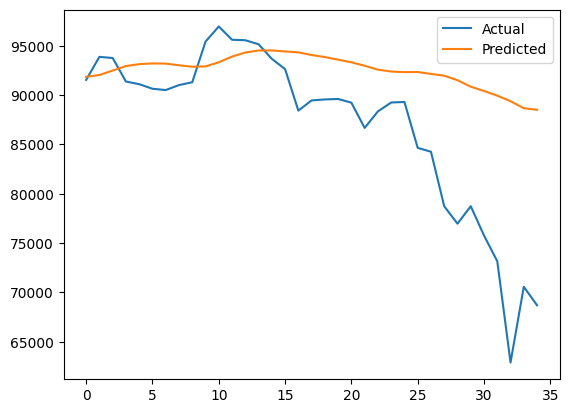

In [49]:
#Test and evaluate
#After training, you can predict BTC prices on the test set and then reverse scale the predictions to original values using the scaler_y.

model.eval()
with torch.no_grad():
    test_pred = model(X_test).numpy()
    # Reverse scaling
    test_pred_original = scaler_y.inverse_transform(test_pred)
    y_test_original = scaler_y.inverse_transform(y_test.numpy())

# Compare predicted vs actual
import matplotlib.pyplot as plt

plt.plot(y_test_original, label='Actual')
plt.plot(test_pred_original, label='Predicted')
plt.legend()
plt.show()


In [50]:
# Import the required metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Make sure your predictions and true values are numpy arrays
# y_test_original = actual Close prices (after inverse scaling)
# test_pred_original = predicted Close prices (after inverse scaling)

mae = mean_absolute_error(y_test_original, test_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, test_pred_original))

# Relative Error (%)
relative_error = (test_pred_original - y_test_original) / y_test_original * 100

print("MAE:", mae)
print("RMSE:", rmse)
print("Relative Error (%)")
print("Min:", relative_error.min())
print("Max:", relative_error.max())
print("Mean:", relative_error.mean())
print("Std:", relative_error.std())


MAE: 6255.70556640625
RMSE: 8965.077132964334
Relative Error (%)
Min: -3.7415564
Max: 42.069675
Mean: 7.3215237
Std: 10.1819515


In [51]:
# Save only the model parameters
torch.save(model.state_dict(), "btc_lstm.pth")
print("Model saved successfully!")


Model saved successfully!
